Скачаем все данные

In [1]:
! wget  -O 'data.csv' -q 'https://www.dropbox.com/scl/fi/39eiebd61yc0cy5ckc7y5/kc_house_data.csv?rlkey=1419a4kcxp081ftjbkh7vtr51&dl=0'

Импортируем нужные модули

In [45]:
%config InlineBackend.figure_format = 'svg'

import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from ensembles import GradientBoostingMSE, RandomForestMSE


In [46]:
random_seed = 42

Посмотрим на данные

In [47]:
data = pd.read_csv('data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [48]:
data.shape

(21613, 21)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Эксперимент 1

Проведите предобработку имеющихся данных. Разделите данные на обучение и контроль, переведите данные в `numpy.ndarray` . Опишите выполненную предобработку данных в отчёте.

Для начала давайте уберем id и сделаем столбец `date`  в формате datetime. столбец `price` является нашим таргетом

P.S. id домов могут повторяться (дома перепродаются) так что надо подумать над обработкой

In [50]:
data[data.id == 795000620]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17602,795000620,20140924T000000,115000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250
17603,795000620,20141215T000000,124000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250
17604,795000620,20150311T000000,157000.0,3,1.0,1080,6250,1.0,0,0,...,5,1080,0,1950,0,98168,47.5045,-122.33,1070,6250


Для простоты отбросим также `zipcode` (код зоны, где расположен дом), `lat` (широта), `long` (долгота) 

In [51]:
data = data.drop(columns=['id', 'zipcode', 'lat', 'long'])

Теперь разберемся со всеми датами в данных

In [52]:
data[['date', 'yr_built', 'yr_renovated']].head(10)

,date,yr_built,yr_renovated
0,20141013T000000,1955,0
1,20141209T000000,1951,1991
2,20150225T000000,1933,0
3,20141209T000000,1965,0
4,20150218T000000,1987,0
5,20140512T000000,2001,0
6,20140627T000000,1995,0
7,20150115T000000,1963,0
8,20150415T000000,1960,0
9,20150312T000000,2003,0


Это не очень информативные признаки, но мы можем преобразовать их в "возраст" дома и время до последнего ремонта

Ноль в `yr_renovated` может означать отсутствие ремонта. Поэтому заменим такие значения годом постройки, а потом сделаем признак обычным вычитанием

In [53]:
data.loc[data['yr_renovated'] == 0, ['yr_renovated']] = data['yr_built']

In [54]:
data[['date', 'yr_built', 'yr_renovated']].head(3)

,date,yr_built,yr_renovated
0,20141013T000000,1955,1955
1,20141209T000000,1951,1991
2,20150225T000000,1933,1933


In [55]:
data['yr_built'] = data['date'].str[0:4].astype(int) - data['yr_built']
data['yr_renovated'] = data['date'].str[0:4].astype(int) - data['yr_renovated']

In [56]:
data[['date', 'yr_built', 'yr_renovated']].head(3)

,date,yr_built,yr_renovated
0,20141013T000000,59,59
1,20141209T000000,63,23
2,20150225T000000,82,82


In [57]:
data = data.drop(columns=['date'])

Давайте теперь проведем анализ на выбросы, чтобы потом на чистых данных посмотреть на корреляции

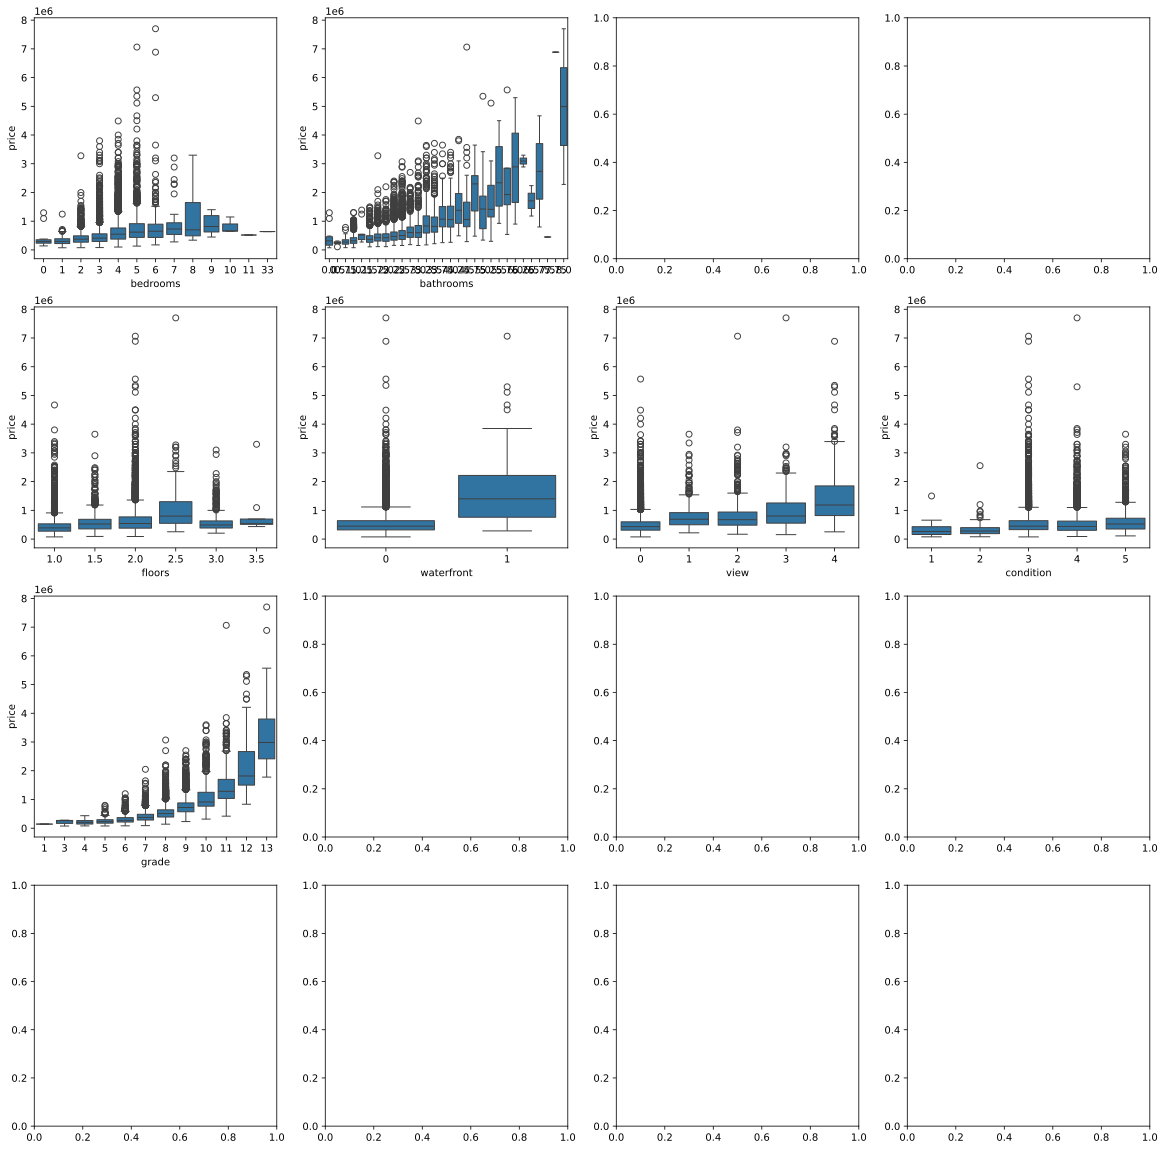

In [58]:
row_num = 4
col_num = 4
fig, axs = plt.subplots(row_num, col_num, figsize=(20, 20))

row = 0
col = 0
for i, column in enumerate(data.drop(columns=['price']).columns):
    row = i // col_num
    col = i % col_num
    if len(data[column].value_counts()) <= 100:
        sns.boxplot(data=data, y='price', x=column, ax=axs[row][col])

In [59]:
tmp = data['bathrooms'].value_counts().sort_index()
print(len(tmp))
tmp

30


bathrooms
0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3048
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: count, dtype: int64

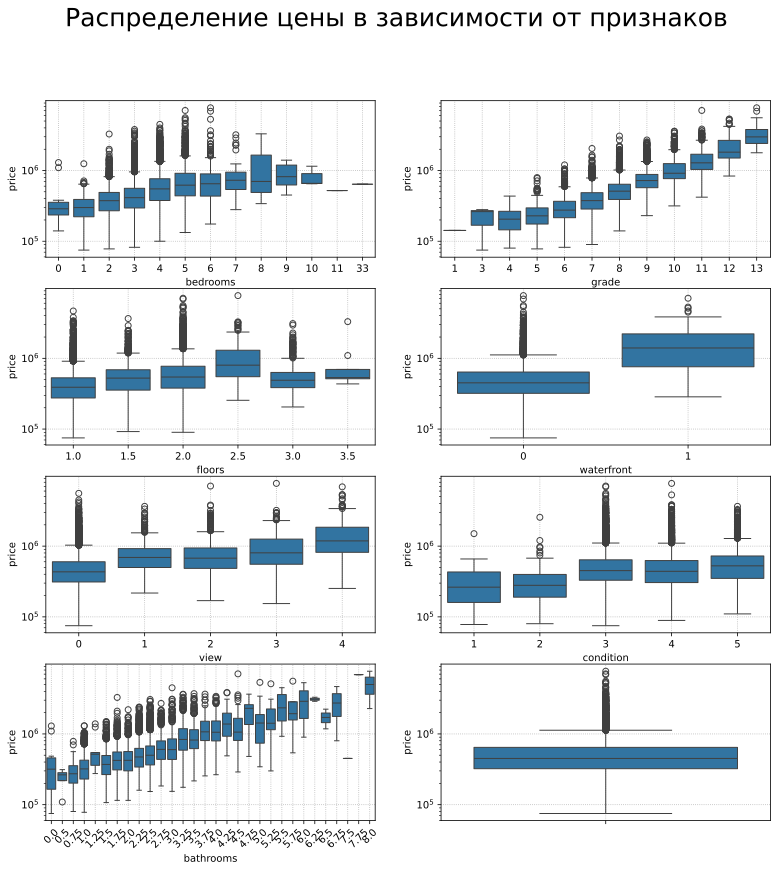

In [60]:
columns = ['bedrooms', 'grade', 'floors', 'waterfront', 'view', 'condition', 'bathrooms']

row_num = 4
col_num = 2
fig, axs = plt.subplots(row_num, col_num, figsize=(13, 13))

fig.suptitle("Распределение цены в зависимости от признаков", fontsize=25)

for i, column in enumerate(columns):
    row = i // col_num
    col = i % col_num
    sns.boxplot(data=data, y='price', x=column, ax=axs[row][col])
    if i == 6:
        axs[row][col].tick_params(axis='x', labelrotation = 45)
    axs[row][col].grid(True, linestyle=':')
    axs[row][col].set_yscale('log')

sns.boxplot(data=data, y='price', ax=axs[row_num - 1][col_num - 1])
axs[row_num - 1][col_num - 1].set_yscale('log')
axs[row_num - 1][col_num - 1].grid(True, linestyle=':')
plt.savefig("pics/price.svg", format='svg')
plt.show()

Видим выбросы в колонке bedrooms. Кто-то продает дома с 11 и 33 спальнями за совсем небольшие деньги)

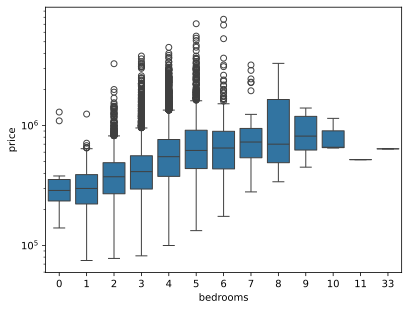

In [61]:
sns.boxplot(data=data, y='price', x='bedrooms')
plt.yscale('log')

In [62]:
data = data.loc[(data['bedrooms'] != 33) & (data['bedrooms'] != 11)]

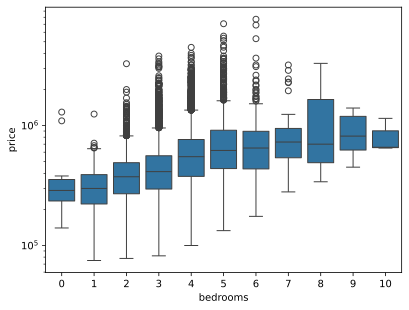

In [63]:
sns.boxplot(data=data, y='price', x='bedrooms')
plt.yscale('log')

В принципе, можно было бы отрезать от цены некоторые значения по квантилю, но мы это делать не будем, так как не знаем задачу в будущем. В крайнем случае можно будет сделать такие же действия на тренировочной выборке.

Давайте посмотрим сейчас на матрицу корреляций

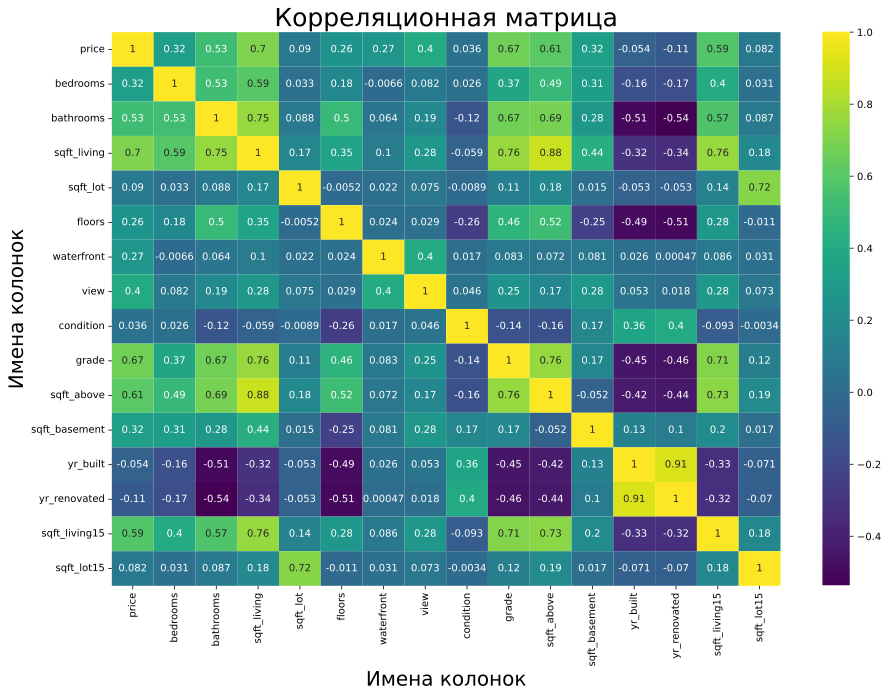

In [67]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), cmap = 'viridis', annot = True)
plt.title("Корреляционная матрица", fontsize=25)
plt.xlabel("Имена колонок", fontsize=20)
plt.ylabel("Имена колонок", fontsize=20)
plt.savefig("pics/corr_matrix.svg", format='svg')
plt.show()

Видим довольно много признаков, которые коррелируют между собой. Оставим из них те, которые лучше коррелируют с нашим таргетом (колонка `price`)

In [68]:
data = data.drop(columns=['yr_built', 'sqft_lot15', 'sqft_above'])

In [69]:
X = data.drop(columns=['price']).to_numpy()
y = data['price'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Эксперимент 2

Исследуйте поведение алгоритма случайный лес. Изучите зависимость RMSE на отложенной выборке и время работы алгоритма в зависимости от следующих факторов:
- количество деревьев в ансамбле
- размерность подвыборки признаков для одного дерева
- максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)

Проверим, что у нас все работает:

In [70]:
np.random.seed(42)
import importlib
import ensembles
importlib.reload(ensembles)
from ensembles import RandomForestMSE

model = RandomForestMSE(100, max_depth=10)#, feature_subsample_size=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

227705.091283906

In [78]:
np.random.seed(random_seed)
n_trees = [10, 30, 50, 70, 100, 200, 350, 500, 1000, 1300]
mse_trees = []
time_trees = []

for n_tree in tqdm(n_trees):
    model = RandomForestMSE(n_tree, max_depth=20)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_trees.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_trees.append(tmp)

100%|██████████| 10/10 [01:49<00:00, 10.91s/it]


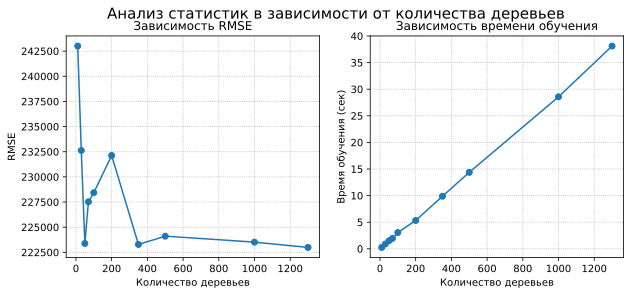

In [79]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик в зависимости от количества деревьев", fontsize=15)

plt.subplot(121)
plt.plot(n_trees, mse_trees, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(n_trees, time_trees, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Количество деревьев")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/rf_n_trees.svg", format='svg')
plt.show()

In [80]:
np.random.seed(random_seed)
feature_size = [0.1, 0.2, 0.33, 0.5, 0.66, 0.8, 0.9, 1.0]
mse_feature = []
time_feature = []

for f_size in tqdm(feature_size):
    model = RandomForestMSE(n_estimators=200,
                            max_depth=20,
                            feature_subsample_size=f_size)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_feature.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_feature.append(tmp)

100%|██████████| 8/8 [01:21<00:00, 10.21s/it]


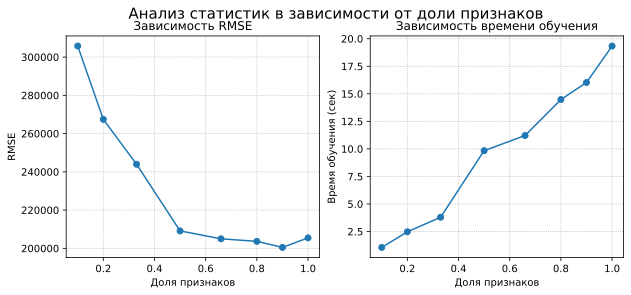

In [81]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик в зависимости от доли признаков", fontsize=15)

plt.subplot(121)
plt.plot(feature_size, mse_feature, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Доля признаков")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(feature_size, time_feature, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Доля признаков")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/rf_feature.svg", format='svg')
plt.show()

In [82]:
np.random.seed(random_seed)
max_depth_arr = [3, 5, 10, 20, 30, 50, None]
mse_depth = []
time_depth = []

for max_depth in tqdm(max_depth_arr):
    model = RandomForestMSE(n_estimators=200,
                            max_depth=max_depth)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_depth.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_depth.append(tmp)

100%|██████████| 7/7 [00:33<00:00,  4.72s/it]


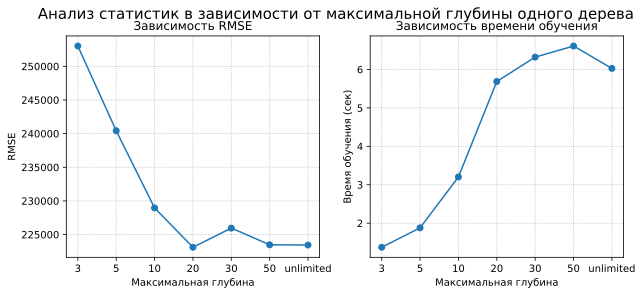

In [83]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик в зависимости от максимальной глубины одного дерева", fontsize=15)

max_depth_arr_new = max_depth_arr[:-1] + ['unlimited']

plt.subplot(121)
plt.plot(max_depth_arr_new, mse_depth, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Максимальная глубина")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(max_depth_arr_new, time_depth, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Максимальная глубина")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/rf_depth.svg", format='svg')
plt.show()

# Эксперимент 3

Исследуйте поведение алгоритма градиентный бустинг. Изучите зависимость RMSE на отложенной выборке и время работы алгоритма в зависимости от следующих факторов:

- количество деревьев в ансамбле
- размерность подвыборки признаков для одного дерева
- максимальная глубина дерева (дополнительно разберите случай, когда глубина неограничена)
- выбранный `learning_rate` (каждый новый алгоритм добавляется в композицию с коэффициентом $\alpha$ · `learning_rate`)

**Замечание:** Для исследования зависимости от количества деревьев не обязательно с нуля переобучать модель.

In [84]:
np.random.seed(42)
import importlib
import ensembles
importlib.reload(ensembles)
from ensembles import GradientBoostingMSE

model = GradientBoostingMSE(10, max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

317154.1831303315

In [85]:
np.random.seed(random_seed)
n_trees = [10, 50, 70, 100, 200, 300, 500, 1000, 1500, 2000]
mse_trees = []
time_trees = []

for n_tree in tqdm(n_trees):
    model = GradientBoostingMSE(n_tree, max_depth=4)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_trees.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_trees.append(tmp)

100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


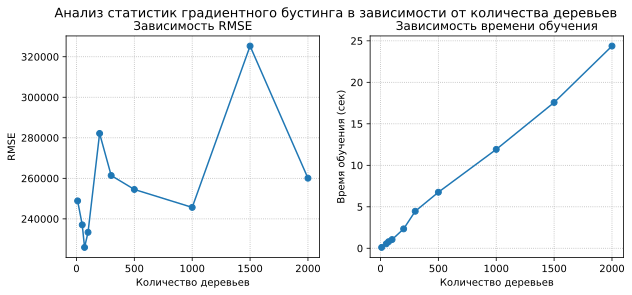

In [94]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик градиентного бустинга в зависимости от количества деревьев", fontsize=13)

plt.subplot(121)
plt.plot(n_trees, mse_trees, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Количество деревьев")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(n_trees, time_trees, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Количество деревьев")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/gd_n_trees.svg", format='svg')
plt.show()

In [88]:
np.random.seed(random_seed)
feature_size = [0.1, 0.2, 0.33, 0.5, 0.66, 0.8, 0.9, 1.0]
mse_feature = []
time_feature = []

for f_size in tqdm(feature_size):
    model = GradientBoostingMSE(n_estimators=100,
                            max_depth=4,
                            feature_subsample_size=f_size)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_feature.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_feature.append(tmp)

100%|██████████| 8/8 [00:13<00:00,  1.69s/it]


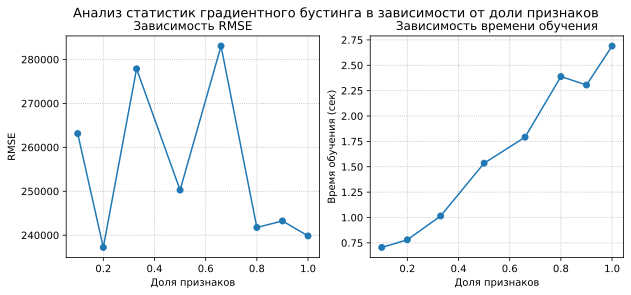

In [95]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик градиентного бустинга в зависимости от доли признаков", fontsize=13)

plt.subplot(121)
plt.plot(feature_size, mse_feature, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Доля признаков")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(feature_size, time_feature, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Доля признаков")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/gd_feature.svg", format='svg')
plt.show()

In [90]:
np.random.seed(random_seed)
max_depth_arr = [3, 5, 10, 20, 30, 50, None]
mse_depth = []
time_depth = []

for max_depth in tqdm(max_depth_arr):
    model = GradientBoostingMSE(n_estimators=100,
                            max_depth=max_depth)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_depth.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_depth.append(tmp)

100%|██████████| 7/7 [00:22<00:00,  3.23s/it]


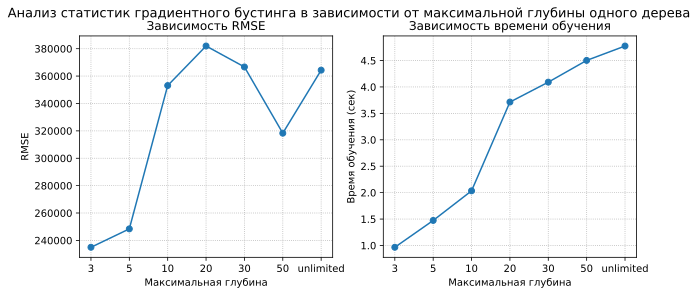

In [96]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик градиентного бустинга в зависимости от максимальной глубины одного дерева", fontsize=13)

max_depth_arr_new = max_depth_arr[:-1] + ['unlimited']

plt.subplot(121)
plt.plot(max_depth_arr_new, mse_depth, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Максимальная глубина")
plt.ylabel("RMSE")

plt.subplot(122)
plt.plot(max_depth_arr_new, time_depth, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Максимальная глубина")
plt.ylabel("Время обучения (сек)")

plt.savefig("pics/gd_depth.svg", format='svg')
plt.show()

In [92]:
np.random.seed(random_seed)
learning_rate = np.logspace(-5, 0, 16)
mse_lr = []
time_lr = []

for lr in tqdm(learning_rate):
    model = GradientBoostingMSE(n_estimators=100,
                            max_depth=3,
                            learning_rate=lr)
    start_time = time.time()
    model.fit(X_train, y_train)
    time_lr.append(time.time() - start_time)
    y_pred = model.predict(X_test)
    tmp = mean_squared_error(y_test, y_pred, squared=False)
    mse_lr.append(tmp)

100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


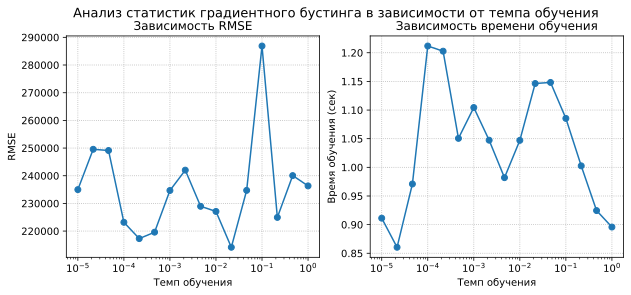

In [97]:
plt.figure(figsize=(10, 4))
plt.suptitle("Анализ статистик градиентного бустинга в зависимости от темпа обучения", fontsize=13)

plt.subplot(121)
plt.plot(learning_rate, mse_lr, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость RMSE")
plt.xlabel("Темп обучения")
plt.ylabel("RMSE")
plt.xscale('log')

plt.subplot(122)
plt.plot(learning_rate, time_lr, marker='o')
plt.grid(True, linestyle=':')
plt.title("Зависимость времени обучения")
plt.xlabel("Темп обучения")
plt.ylabel("Время обучения (сек)")
plt.xscale('log')

plt.savefig("pics/gd_lr.svg", format='svg')
plt.show()